# Analysing approximate HDBSCAN*

The purpose of this notebook is to assess the quality of clustering results with HDBSCAN* using approximate strategies.
Also, this also serves as an experiment on how we can reuse the functions already available at HDBSCAN*'s python implementation.

In [62]:
import utils

import hdbscan
import numpy as np
import pandas as pd

from sklearn import cluster, datasets, mixture

from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.pairwise import euclidean_distances

from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

import matplotlib.pyplot as plt

import pynndescent

### Let's use this space to define some useful variables, shall we?

In [63]:
files = {
1:'Datasetssets/blobs_seed_1227_size_1000_centers_4.csv',
2:'Datasets/blobs_seed_1227_size_10000_centers_5.csv',
3:'Datasets/blobs_seed_1227_size_100000_centers_6.csv',
4:'Datasets/blobs_seed_1227_size_1000000_centers_7.csv',
5:'Datasets/blobs_size_100_centers_10_outliers_0.csv',
6:'Datasets/blobs_size_1000_centers_4_outliers_100.csv',
7:'Datasets/blobs_size_1000_centers_7_outliers_50.csv',
8:'Datasets/blobs_size_1000_centers_10_outliers_0.csv',
9:'Datasets/blobs_size_1000_centers_10_outliers_50.csv',
10:'Datasets/blobs_size_1000_centers_10_outliers_100.csv',
11:'Datasets/blobs_size_1000_centers_10_outliers_150.csv',
12:'Datasets/blobs_size_2000_centers_20_outliers_0.csv',
13:'Datasets/blobs_size_10000_centers_7_outliers_500.csv',
14:'Datasets/blobs_size_10000_centers_7_outliers_1000.csv',
15:'Datasets/blobs_size_10000_centers_10_outliers_0.csv',
16:'Datasets/blobs_size_10000_centers_10_outliers_1000.csv',
17:'Datasets/circles_seed_1227_size_1000.csv',
18:'Datasets/moons_size_1000_outliers_0.csv',
19:'Datasets/moons_size_1000_outliers_100.csv',
20:'Datasets/swissroll_seed_1227_size_1000.csv',
21:'Datasets/swissroll_seed_1227_size_10000.csv',
22:'Datasets/swissroll_seed_1227_size_100000.csv',
23:'Datasets/swissroll_seed_1227_size_1000000.csv',
24:'Datasets/test_blobs_seed_231_size_1000_centers_4.csv',
25:'Datasets/test_blobs_seed_1227_size_1000_centers_4.csv',
26:'Datasets/test_blobs_size_1000_centers_4_outliers_100.csv',
27:'Datasets/horseshoe.csv',
28:'Datasets/blobs_size_2000_centers_10_outliers_20.csv',
29:'Datasets/badmoons.csv'
}

# Number of neighbors for k-NN queries.
k = 10

# Path of the data file (in CSV format, please!)
datafile = files[8]

# Sampling rate (0 < s <= 1)
s = 0.05

### Loading data 

Next, we create some datasets and put them on a dictionary so we can easily access them.

In [64]:
data = pd.read_csv(datafile, header=None).values
# data, _ = datasets.make_circles(n_samples=20, factor=.5, noise=.05)

### Building the input graph to HDBSCAN*

The cell bellow computes the **MST** and the **CORE-SG** graph for a sample of the dataset.

In [65]:
sample, idx = utils.sample_data(data, sample_rate=s)

mst_sample = minimum_spanning_tree(euclidean_distances(sample))
mst_sample = mst_sample.maximum(mst_sample.T)

knn_sample = kneighbors_graph(sample, k, mode='distance', include_self=False)
knn_sample = knn_sample.maximum(knn_sample.T)

csg_sample = knn_sample.copy().maximum(mst_sample.copy())

Now, let's make some input graphs by merging those graphs with an approximate **k-NNG** for the entire dataset.

In [66]:
# Compute the kNN graph of the entire data
knng = kneighbors_graph(data, k, mode='distance', include_self=False)
knng = knng.maximum(knng.T)

input_knn_core = utils.merge_edges(knng, csg_sample, idx)
input_knn_mst  = utils.merge_edges(knng, mst_sample, idx)

input_knn_core = input_knn_core.maximum(input_knn_core.T)
input_knn_mst  = input_knn_mst.maximum(input_knn_mst.T)

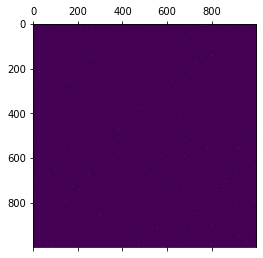

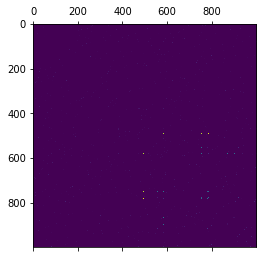

In [67]:
max_value = max(input_knn_mst.max(), input_knn_core.max())

plt.matshow(input_knn_mst.A, fignum=None, vmin=0, vmax=max_value)
plt.matshow(input_knn_core.A, fignum=None, vmin=0, vmax=max_value)

In [68]:
mst_test_mst = minimum_spanning_tree(input_knn_mst)
mst_test_mst.sum()

326.9596592626714

In [69]:
mst_test_core = minimum_spanning_tree(input_knn_core)
mst_test_core.sum()

326.9596592626714

### Constructing the HDBSCAN* object to cluster the data

In [70]:
def labels_and_tree(input_data, itype='graph'):

    if itype == 'graph':
        clusterer = hdbscan.HDBSCAN(
            metric='precomputed',
            min_samples=k, 
            min_cluster_size=2,
            approx_min_span_tree=False,
            gen_min_span_tree=True,
            match_reference_implementation=True)
    else:
        clusterer = hdbscan.HDBSCAN(
            metric='euclidean', 
            min_samples=k+1, 
            min_cluster_size=2,
            approx_min_span_tree=False,
            gen_min_span_tree=True,
            match_reference_implementation=True)
        
    a = clusterer.fit(input_data)
    
    return clusterer.labels_, clusterer.single_linkage_tree_.to_numpy(), clusterer.condensed_tree_, clusterer._min_spanning_tree

    
labels_knn_mst,  sltree_knn_mst,  ctree_knn_mst,  rmst_knn_mst  = labels_and_tree(input_knn_mst)
labels_knn_core, sltree_knn_core, ctree_knn_core, rmst_knn_core = labels_and_tree(input_knn_core)
labels_exact,    sltree_exact,    ctree_exact,    rmst_exact    = labels_and_tree(data, itype='data')

### It's time to plot some data...

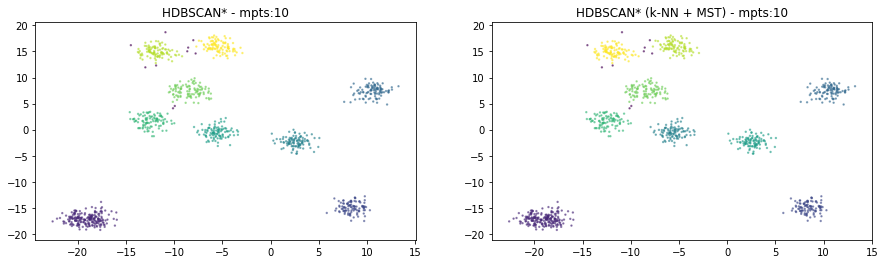

In [71]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

axs[0].title.set_text('HDBSCAN* - mpts:' + str(k))
axs[0].scatter(data[:,0], data[:,1], s=2, c=labels_exact, alpha=0.5)

axs[1].title.set_text('HDBSCAN* (k-NN + MST) - mpts:' + str(k))
axs[1].scatter(data[:,0], data[:,1], s=2, c=labels_knn_mst, alpha=0.5)

#axs[2].title.set_text('HDBSCAN* (k-NN + CORE-SG) - mpts:' + str(k))
#axs[2].scatter(data[:,0], data[:,1], s=2, c=labels_knn_core, alpha=0.5)

<AxesSubplot:title={'center':'HDBSCAN* (k-NN + MST) - mpts:10'}, ylabel='$\\lambda$ value'>

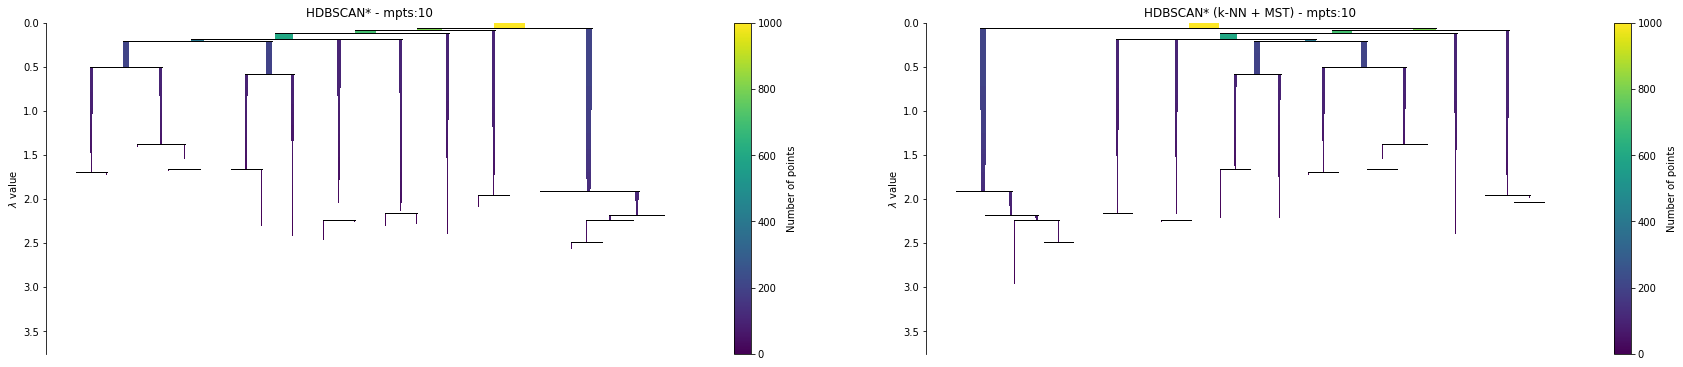

In [72]:
fig_t, axs_t = plt.subplots(nrows=1, ncols=2, figsize=(25,6))
fig_t.tight_layout(pad=4.0)

axs_t[0].title.set_text('HDBSCAN* - mpts:' + str(k))
ctree_knn_mst.plot(axis=axs_t[0])

axs_t[1].title.set_text('HDBSCAN* (k-NN + MST) - mpts:' + str(k))
ctree_knn_core.plot(axis=axs_t[1])

#axs_t[2].title.set_text('HDBSCAN* (k-NN + CORE-SG) - mpts:' + str(k))
#ctree_exact.plot(axis=axs_t[2])

### Ok, maybe now we should look at some numbers...

In [73]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score

ari = adjusted_rand_score(labels_exact, labels_knn_mst)
nmi = normalized_mutual_info_score(labels_exact, labels_knn_mst)

print("Exact vs. KNN + MST(sample)")
print("ARI: ", ari)
print("NMI: ", nmi)

ari = adjusted_rand_score(labels_exact, labels_knn_core)
nmi = normalized_mutual_info_score(labels_exact, labels_knn_core)

print("Exact vs. KNN + CORE-SG(sample)")
print("ARI: ", ari)
print("NMI: ", nmi)

ari = adjusted_rand_score(labels_knn_mst, labels_knn_core)
nmi = normalized_mutual_info_score(labels_knn_mst, labels_knn_core)

print("KNN + MST(sample) vs. KNN + CORE-SG(sample)")
print("ARI: ", ari)
print("NMI: ", nmi)


Exact vs. KNN + MST(sample)
ARI:  1.0
NMI:  1.0
Exact vs. KNN + CORE-SG(sample)
ARI:  1.0
NMI:  1.0
KNN + MST(sample) vs. KNN + CORE-SG(sample)
ARI:  1.0
NMI:  1.0


### What about the Hierarchy Agreement Index (HAI) between the approximate hierarchies and the exact one?

In [74]:
hai_knn_mst  = utils.hai(sltree_knn_mst, sltree_exact)
hai_knn_core = utils.hai(sltree_knn_core, sltree_exact)
hai_mst_core = utils.hai(sltree_knn_mst, sltree_knn_core)

print("Exact vs. KNN + MST(sample): ", hai_knn_mst)
print("Exact vs. KNN + CORE-SG(sample): ", hai_knn_core)
print("KNN + MST(sample) vs. KNN + CORE-SG(sample): ", hai_mst_core)

Exact vs. KNN + MST(sample):  0.90625
Exact vs. KNN + CORE-SG(sample):  1.0
KNN + MST(sample) vs. KNN + CORE-SG(sample):  0.90625


In [75]:
print("[k-NN + MST] Sum of edge weights:", sum(rmst_knn_mst[:,2]).tolist()[0][0])
print("[k-NN + CSG] Sum of edge weights:", sum(rmst_knn_core[:,2]).tolist()[0][0])
print("[COMPLETE G] Sum of edge weights:", sum(rmst_exact[:,2]))

[k-NN + MST] Sum of edge weights: 781.1669994679576
[k-NN + CSG] Sum of edge weights: 781.1669994679576
[COMPLETE G] Sum of edge weights: 765.1759949296896
